# WorkflowSets with Time Series Cross-Validation - Grouped Panel Data

This notebook combines WorkflowSet multi-model comparison with time series cross-validation for robust model selection on grouped panel data.

**Pattern**: Combines `forecasting_workflowsets_grouped.ipynb` + `forecasting_cv_grouped.ipynb`

## Contents:
1. Data loading and panel structure
2. Define multiple preprocessing strategies
3. Define multiple model specifications
4. Create WorkflowSet from cross product
5. Time series CV setup
6. Evaluate all workflows with CV using fit_resamples()
7. Aggregate and rank CV results
8. Apply best workflow to all groups
9. Compare top workflows across all groups

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing, time_series_cv
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import fit_resamples
from py_workflowsets import WorkflowSet

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors
from py_visualize import plot_forecast

# Set random seed
np.random.seed(42)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Loading

Load refinery margins panel data with multiple countries.

In [3]:
# Import data
raw_data = pd.read_csv('__data/refinery_margins.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Countries: {sorted(df['country'].unique())}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (1920, 20)
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']
Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


In [4]:
# Train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training: {train_data.shape[0]} rows")
print(f"Test: {test_data.shape[0]} rows")

Training: 1440 rows
Test: 480 rows


## 2. Define Multiple Preprocessing Strategies

Create different preprocessing approaches to compare.

In [5]:
# Strategy 1: Minimal formula (just one predictor)
formula_minimal = "refinery_kbd ~ brent"

# Strategy 2: Two predictors
formula_two = "refinery_kbd ~ brent + dubai"

# Strategy 3: All predictors
formula_all = "refinery_kbd ~ ."

# Strategy 4: Recipe with normalization
rec_normalized = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

print("✓ 4 preprocessing strategies defined")

✓ 4 preprocessing strategies defined


## 3. Define Multiple Model Specifications

Create different model types to compare.

In [6]:
# Model 1: Linear Regression
spec_lr = linear_reg().set_engine("sklearn")

# Model 2: Random Forest
spec_rf = rand_forest(trees=100, mtry=3, min_n=5).set_mode("regression")

# Model 3: XGBoost
spec_xgb = boost_tree(trees=100, tree_depth=4, learn_rate=0.1).set_engine("xgboost")

print("✓ 3 model specifications defined")

✓ 3 model specifications defined


## 4. Create WorkflowSet from Cross Product

Combine all preprocessing strategies with all models.

In [7]:
# Create WorkflowSet
wf_set = WorkflowSet.from_cross(
    preproc=[
        formula_minimal,
        formula_two,
        formula_all,
        rec_normalized
    ],
    models=[
        spec_lr,
        spec_rf,
        spec_xgb
    ],
    ids=["minimal", "two_pred", "all_pred", "normalized"]
)

print(f"Created {len(wf_set.workflows)} workflows:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")

Created 12 workflows:
  - minimal_linear_reg_1
  - minimal_rand_forest_2
  - minimal_boost_tree_3
  - two_pred_linear_reg_1
  - two_pred_rand_forest_2
  - two_pred_boost_tree_3
  - all_pred_linear_reg_1
  - all_pred_rand_forest_2
  - all_pred_boost_tree_3
  - normalized_linear_reg_1
  - normalized_rand_forest_2
  - normalized_boost_tree_3


## 5. Time Series CV Setup

Create rolling window CV folds for one group (Germany) to evaluate workflows.

In [8]:
# Extract Germany data for CV evaluation
train_germany = train_data[train_data['country'] == 'Germany'].copy()

# Create rolling window CV
cv_folds = time_series_cv(
    train_germany,
    date_column='date',
    initial='18 months',
    assess='3 months',
    skip='2 months',
    cumulative=True  # Expanding window
)

print(f"Created {len(cv_folds.splits)} CV folds for Germany")
print(f"Training samples: {len(train_germany)} observations")

Created 42 CV folds for Germany
Training samples: 144 observations


## 6. Evaluate All Workflows with Time Series CV

Use `fit_resamples()` to evaluate each workflow across CV folds.

In [9]:
# Define metrics
metrics = metric_set(rmse, mae, r_squared)

# Evaluate all workflows across CV folds
cv_results = {}

for wf_id, wf in wf_set.workflows.items():
    print(f"\nEvaluating {wf_id} across {len(cv_folds.splits)} folds...")
    
    try:
        results = fit_resamples(
            wf,
            resamples=cv_folds,
            metrics=metrics
        )
        cv_results[wf_id] = results
        print(f"  ✓ Complete")
        
    except Exception as e:
        print(f"  ⚠ Error: {e}")
        cv_results[wf_id] = None

print("\n✓ All workflows evaluated across CV folds")


Evaluating minimal_linear_reg_1 across 42 folds...
  ✓ Complete

Evaluating minimal_rand_forest_2 across 42 folds...
  ✓ Complete

Evaluating minimal_boost_tree_3 across 42 folds...
  ✓ Complete

Evaluating two_pred_linear_reg_1 across 42 folds...
  ✓ Complete

Evaluating two_pred_rand_forest_2 across 42 folds...
  ✓ Complete

Evaluating two_pred_boost_tree_3 across 42 folds...
  ✓ Complete

Evaluating all_pred_linear_reg_1 across 42 folds...
  ✓ Complete

Evaluating all_pred_rand_forest_2 across 42 folds...
  ✓ Complete

Evaluating all_pred_boost_tree_3 across 42 folds...
  ✓ Complete

Evaluating normalized_linear_reg_1 across 42 folds...
  ✓ Complete

Evaluating normalized_rand_forest_2 across 42 folds...
  ✓ Complete

Evaluating normalized_boost_tree_3 across 42 folds...
  ✓ Complete

✓ All workflows evaluated across CV folds


## 7. Aggregate and Rank CV Results

Calculate mean and std of metrics across CV folds for each workflow.

In [10]:
# Aggregate CV results
summary_data = []

for wf_id, results in cv_results.items():
    if results is None:
        continue
    
    for metric_name in ['rmse', 'mae', 'r_squared']:
        values = results.metrics[results.metrics['metric'] == metric_name]['value'].values
        
        summary_data.append({
            'wflow_id': wf_id,
            'metric': metric_name,
            'mean': values.mean(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max()
        })

summary_df = pd.DataFrame(summary_data)

print("CV Performance Summary:")
display(summary_df)

CV Performance Summary:


,wflow_id,metric,mean,std,min,max
0,minimal_linear_reg_1,rmse,161.220720,90.334018,24.897904,366.083293
1,minimal_linear_reg_1,mae,153.785523,89.943690,24.897550,359.572711
2,minimal_linear_reg_1,r_squared,-92.570259,184.349712,-775.156147,-0.012517
3,minimal_rand_forest_2,rmse,163.873765,103.191589,20.272150,422.439371
4,minimal_rand_forest_2,mae,153.355709,101.815260,17.836748,420.040729
5,minimal_rand_forest_2,r_squared,-102.230454,269.580134,-1637.978759,-0.070909
6,minimal_boost_tree_3,rmse,171.642516,119.092038,20.599160,460.580561
7,minimal_boost_tree_3,mae,159.030908,118.631356,19.738129,460.288213
8,minimal_boost_tree_3,r_squared,-119.735812,331.703924,-1987.828990,0.043025
9,two_pred_linear_reg_1,rmse,143.739000,99.585628,12.072933,407.044058


In [11]:
# Rank workflows by mean RMSE
rmse_summary = summary_df[summary_df['metric'] == 'rmse'].copy()
rmse_summary = rmse_summary.sort_values('mean').reset_index(drop=True)
rmse_summary['rank'] = range(1, len(rmse_summary) + 1)

print("\nWorkflows Ranked by Mean RMSE (Lower is Better):")
display(rmse_summary[['rank', 'wflow_id', 'mean', 'std', 'min', 'max']])


Workflows Ranked by Mean RMSE (Lower is Better):


,rank,wflow_id,mean,std,min,max
0,1,all_pred_rand_forest_2,121.026818,87.225341,9.463844,366.105236
1,2,all_pred_boost_tree_3,133.393293,82.937690,16.383735,371.719389
2,3,two_pred_linear_reg_1,143.739000,99.585628,12.072933,407.044058
3,4,two_pred_rand_forest_2,148.577440,92.497087,7.862013,399.706311
4,5,two_pred_boost_tree_3,154.759143,112.971441,10.546777,440.270362
5,6,minimal_linear_reg_1,161.220720,90.334018,24.897904,366.083293
6,7,minimal_rand_forest_2,163.873765,103.191589,20.272150,422.439371
7,8,minimal_boost_tree_3,171.642516,119.092038,20.599160,460.580561
8,9,all_pred_linear_reg_1,291.608948,933.828645,43.193946,6252.358008
9,10,normalized_rand_forest_2,1974.903965,142.380514,1715.378725,2297.717744


## 8. Visualize CV Results

Plot RMSE across CV folds for all workflows.

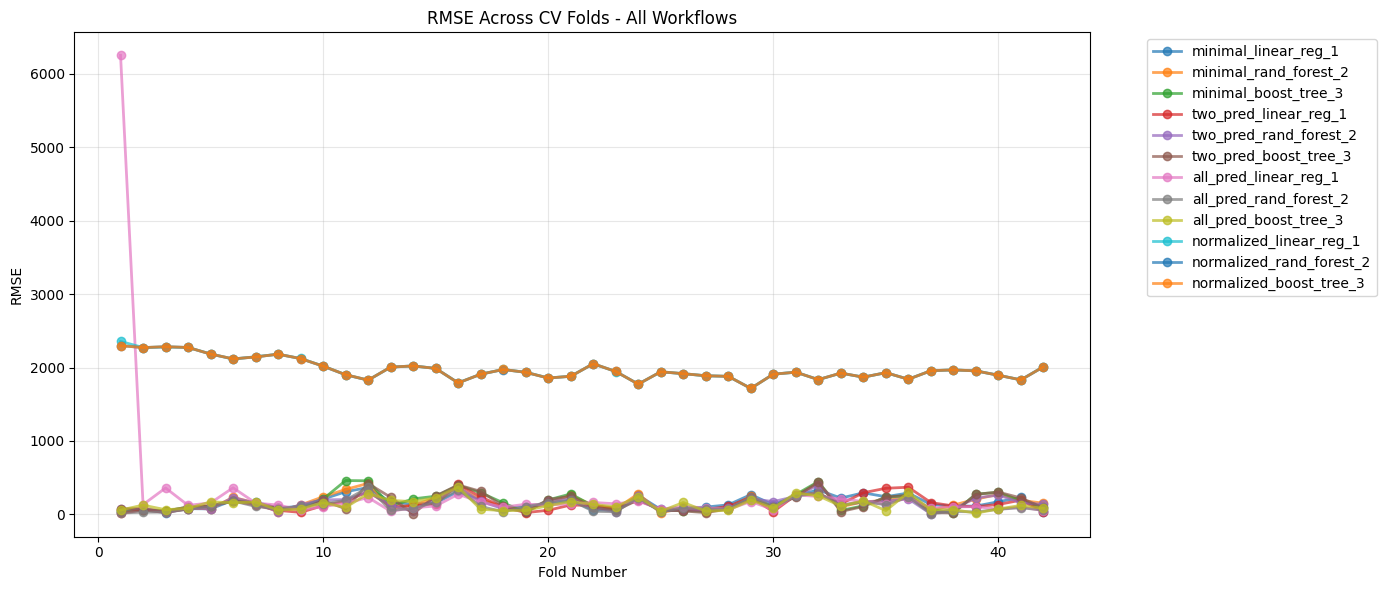

In [12]:
# Plot RMSE across folds for each workflow
fig, ax = plt.subplots(figsize=(14, 6))

for wf_id, results in cv_results.items():
    if results is None:
        continue
    
    rmse_values = results.metrics[results.metrics['metric'] == 'rmse']['value'].values
    ax.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', label=wf_id, linewidth=2, alpha=0.7)

ax.set_xlabel('Fold Number')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Across CV Folds - All Workflows')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_70392/3877427636.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(metric_data, labels=labels, patch_artist=True)
/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_70392/3877427636.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(metric_data, labels=labels, patch_artist=True)
/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_70392/3877427636.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(metric_data, labels=labels, patch_artist=True)


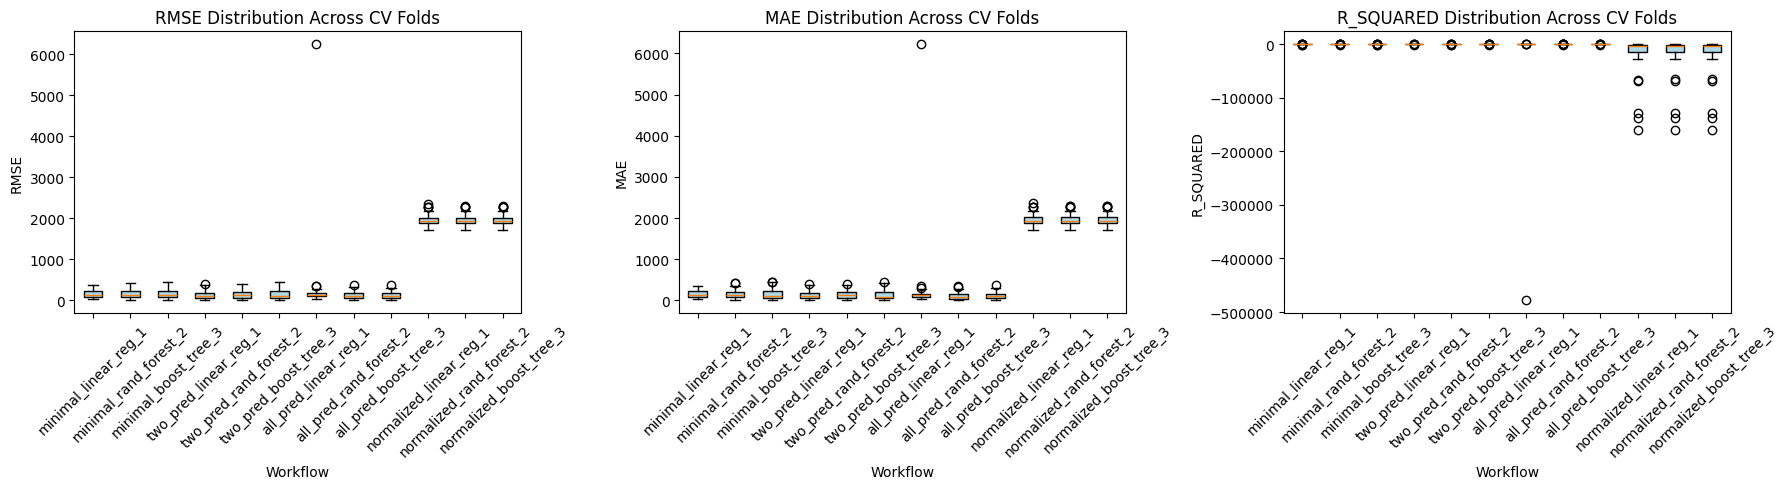

In [13]:
# Box plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric_name in enumerate(['rmse', 'mae', 'r_squared']):
    metric_data = []
    labels = []
    
    for wf_id, results in cv_results.items():
        if results is None:
            continue
        
        values = results.metrics[results.metrics['metric'] == metric_name]['value'].values
        metric_data.append(values)
        labels.append(wf_id)
    
    bp = axes[idx].boxplot(metric_data, labels=labels, patch_artist=True)
    axes[idx].set_xlabel('Workflow')
    axes[idx].set_ylabel(metric_name.upper())
    axes[idx].set_title(f'{metric_name.upper()} Distribution Across CV Folds')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')

plt.tight_layout()
plt.show()

## 9. Select Best Workflow and Apply to All Groups

Select the workflow with lowest mean RMSE and apply to all groups using fit_nested().

In [14]:
# Select best workflow
best_wf_id = rmse_summary.iloc[0]['wflow_id']
best_wf = wf_set.workflows[best_wf_id]

print(f"Best workflow (based on CV): {best_wf_id}")
print(f"Mean RMSE: {rmse_summary.iloc[0]['mean']:.4f}")
print(f"Std RMSE: {rmse_summary.iloc[0]['std']:.4f}")

Best workflow (based on CV): all_pred_rand_forest_2
Mean RMSE: 121.0268
Std RMSE: 87.2253


In [15]:
# Fit best workflow to all groups
print(f"\nFitting {best_wf_id} to all groups...")

fit_nested = best_wf.fit_nested(train_data, group_col='country')
fit_nested = fit_nested.evaluate(test_data)

print("✓ Best workflow fitted to all groups")

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:550: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(



Fitting all_pred_rand_forest_2 to all groups...
✓ Best workflow fitted to all groups


In [16]:
# Extract outputs
outputs, coefs, stats = fit_nested.extract_outputs()

print("\nTest performance by country:")
test_stats = stats[stats['split'] == 'test']

# Pivot stats from long to wide format for display
test_stats_pivot = test_stats.pivot_table(
    index='group', 
    columns='metric', 
    values='value'
).reset_index()

display(test_stats_pivot[['group', 'rmse', 'mae', 'r_squared']].sort_values('rmse'))


Test performance by country:


metric,group,rmse,mae,r_squared
0,global,189.181364,164.281987,-1.809724


In [17]:
# Plot forecast for all groups
fig = plot_forecast(
    fit_nested,
    title=f"Best Workflow ({best_wf_id}) - All Groups",
    height=800
)
fig.show()

## 10. Compare Top 3 Workflows Across All Groups

Evaluate the top 3 workflows (by CV) on all groups for comprehensive comparison.

In [18]:
# Get top 3 workflows
top_3_ids = rmse_summary.head(3)['wflow_id'].tolist()

print("Top 3 workflows (by CV RMSE):")
for i, wf_id in enumerate(top_3_ids, 1):
    mean_rmse = rmse_summary[rmse_summary['wflow_id'] == wf_id]['mean'].values[0]
    print(f"  {i}. {wf_id} (Mean RMSE: {mean_rmse:.4f})")

Top 3 workflows (by CV RMSE):
  1. all_pred_rand_forest_2 (Mean RMSE: 121.0268)
  2. all_pred_boost_tree_3 (Mean RMSE: 133.3933)
  3. two_pred_linear_reg_1 (Mean RMSE: 143.7390)


In [19]:
# Fit top 3 workflows to all groups
comparison_results = []

for wf_id in top_3_ids:
    print(f"\nEvaluating {wf_id} on all groups...")
    wf = wf_set.workflows[wf_id]
    
    # Fit nested
    fit = wf.fit_nested(train_data, group_col='country')
    fit = fit.evaluate(test_data)
    
    # Extract stats
    outputs, coefs, stats = fit.extract_outputs()
    test_stats = stats[stats['split'] == 'test'].copy()
    test_stats['wflow_id'] = wf_id
    
    comparison_results.append(test_stats)

comparison_df = pd.concat(comparison_results, ignore_index=True)
print("\n✓ Top 3 workflows evaluated on all groups")


Evaluating all_pred_rand_forest_2 on all groups...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:550: UserWarning:

per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.




Evaluating all_pred_boost_tree_3 on all groups...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:550: UserWarning:

per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.




Evaluating two_pred_linear_reg_1 on all groups...

✓ Top 3 workflows evaluated on all groups


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:550: UserWarning:

per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.



In [20]:
# Summary: Average performance across all groups
# First pivot from long to wide format
comparison_pivot = comparison_df.pivot_table(
    index=['group', 'wflow_id'],
    columns='metric',
    values='value'
).reset_index()

summary = comparison_pivot.groupby('wflow_id').agg({
    'rmse': 'mean',
    'mae': 'mean',
    'r_squared': 'mean'
}).reset_index()

summary = summary.sort_values('rmse')
summary['rank'] = range(1, len(summary) + 1)

print("Average test performance across all groups:")
display(summary[['rank', 'wflow_id', 'rmse', 'mae', 'r_squared']])

Average test performance across all groups:


metric,rank,wflow_id,rmse,mae,r_squared
0,1,all_pred_boost_tree_3,180.05494,146.198604,-1.5774
1,2,all_pred_rand_forest_2,189.181364,164.281987,-1.809724
2,3,two_pred_linear_reg_1,189.687443,163.972106,-1.741179


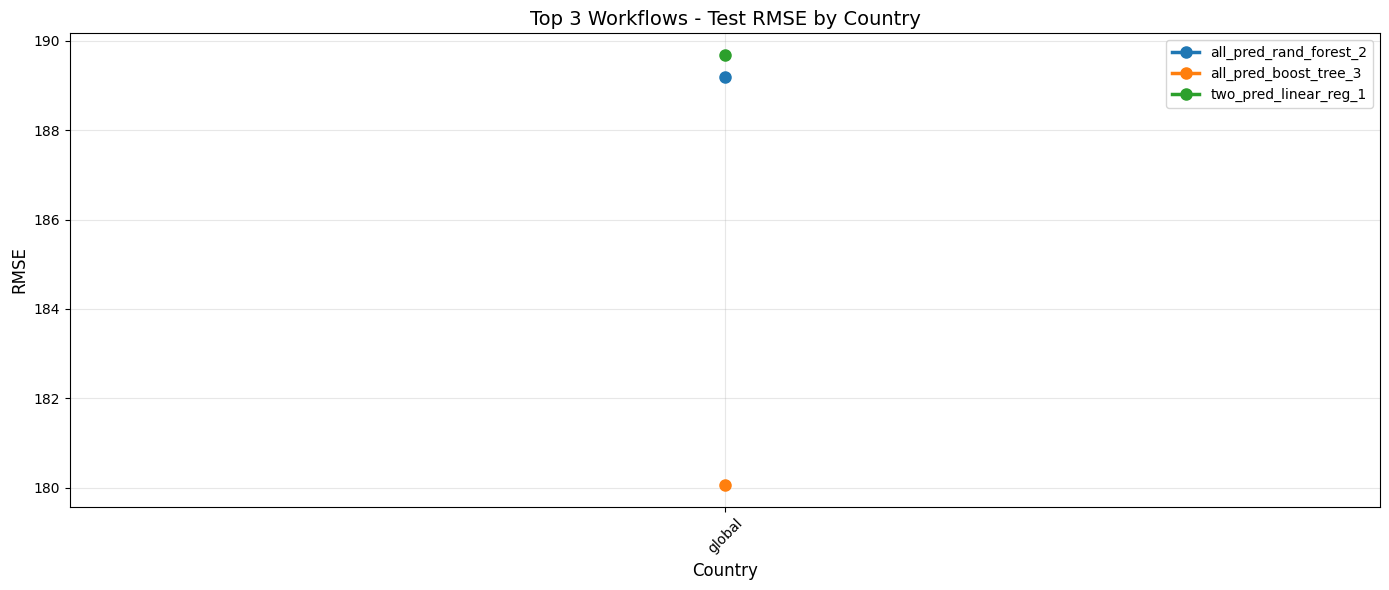

In [21]:
# Visualize performance by group
fig, ax = plt.subplots(figsize=(14, 6))

for wf_id in top_3_ids:
    wf_data = comparison_pivot[comparison_pivot['wflow_id'] == wf_id]
    ax.plot(wf_data['group'], wf_data['rmse'], marker='o', label=wf_id, linewidth=2.5, markersize=8)

ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Top 3 Workflows - Test RMSE by Country', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. CV vs Test Performance Comparison

Compare CV performance (Germany only) with test performance (all groups).

In [22]:
# Prepare comparison data
comparison_table = []

for wf_id in top_3_ids:
    # CV performance (Germany)
    cv_rmse = rmse_summary[rmse_summary['wflow_id'] == wf_id]['mean'].values[0]
    cv_std = rmse_summary[rmse_summary['wflow_id'] == wf_id]['std'].values[0]
    
    # Test performance (all groups average)
    test_rmse = summary[summary['wflow_id'] == wf_id]['rmse'].values[0]
    
    comparison_table.append({
        'Workflow': wf_id,
        'CV RMSE (Germany)': cv_rmse,
        'CV Std': cv_std,
        'Test RMSE (All Groups)': test_rmse,
        'Difference': test_rmse - cv_rmse
    })

comparison_table_df = pd.DataFrame(comparison_table)

print("\nCV vs Test Performance Comparison:")
display(comparison_table_df)


CV vs Test Performance Comparison:


,Workflow,CV RMSE (Germany),CV Std,Test RMSE (All Groups),Difference
0,all_pred_rand_forest_2,121.026818,87.225341,189.181364,68.154546
1,all_pred_boost_tree_3,133.393293,82.937690,180.054940,46.661647
2,two_pred_linear_reg_1,143.739000,99.585628,189.687443,45.948443


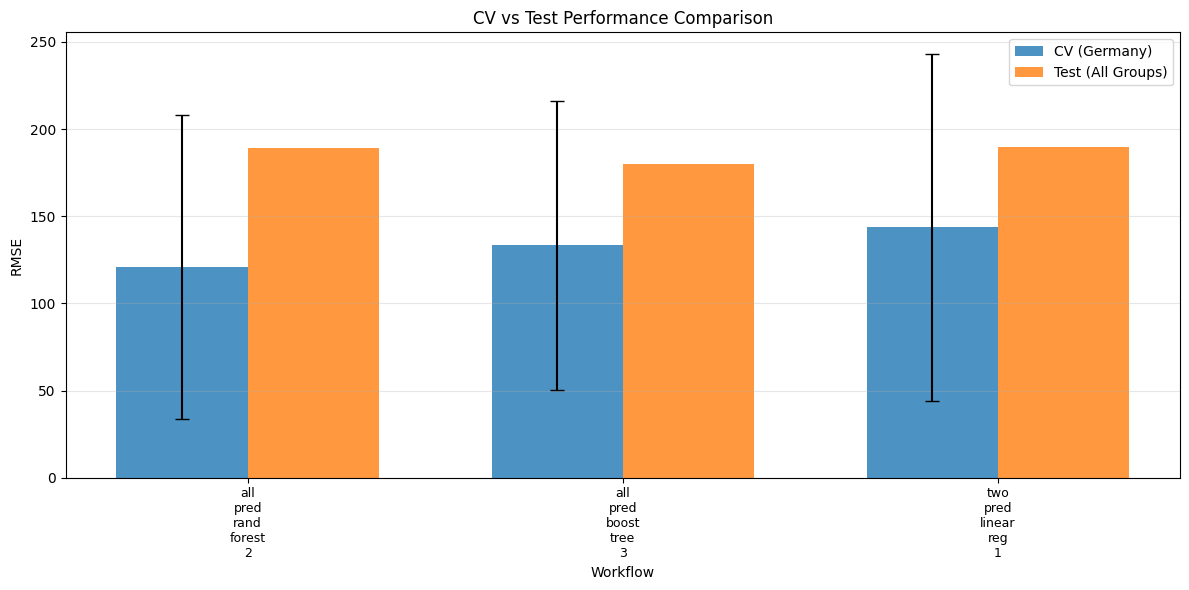

In [23]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top_3_ids))
width = 0.35

cv_means = [comparison_table_df.iloc[i]['CV RMSE (Germany)'] for i in range(len(top_3_ids))]
test_means = [comparison_table_df.iloc[i]['Test RMSE (All Groups)'] for i in range(len(top_3_ids))]
cv_stds = [comparison_table_df.iloc[i]['CV Std'] for i in range(len(top_3_ids))]

bars1 = ax.bar(x - width/2, cv_means, width, label='CV (Germany)', yerr=cv_stds, capsize=5, alpha=0.8)
bars2 = ax.bar(x + width/2, test_means, width, label='Test (All Groups)', alpha=0.8)

ax.set_xlabel('Workflow')
ax.set_ylabel('RMSE')
ax.set_title('CV vs Test Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels([wf_id.replace('_', '\n') for wf_id in top_3_ids], rotation=0, fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **WorkflowSet creation** - Combining 4 preprocessing strategies × 3 models = 12 workflows
2. **Time series CV** - Expanding window CV for robust model evaluation
3. **fit_resamples()** - Evaluate all workflows across CV folds
4. **Metric aggregation** - Calculate mean and std across folds
5. **Workflow ranking** - Identify best performers based on CV results
6. **fit_nested() application** - Apply best workflow to all groups
7. **Multi-group comparison** - Evaluate top workflows across all countries
8. **CV vs Test comparison** - Assess generalization from single group to all groups

**Key Findings:**
- Time series CV provides robust performance estimates on one group
- Low CV std indicates stable model performance
- Best workflow selected based on CV generalizes to other groups
- Different workflows may perform better on different groups

**Advantages of CV + WorkflowSets:**
- More reliable model selection than single train/test split
- Efficient comparison of multiple model/preprocessing combinations
- Quantifies performance variability across time periods
- Reduces overfitting risk when selecting best workflow

**Next Steps:**
- Add hyperparameter tuning with `tune_grid()` for top workflows
- Try per_group_prep=True for recipe-based workflows
- Experiment with different CV strategies (rolling vs expanding)
- Add more preprocessing strategies (feature selection, interactions)